# Importing Libraries

In [52]:
import cv2
from tqdm import tqdm
from ultralytics import YOLO
import supervision as sv
from typing import Iterable, Dict, List, Optional, Set
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import math
import json

In [53]:
ZONE_HEX_COLORS = ["#E6194B", "#3CB44B", "#FFE119", "#3C76D1"]
ZONE_COLOR_NAMES = ["Red", "Green", "Yellow", "Blue"]
ZONE_COLORS = sv.ColorPalette.from_hex(ZONE_HEX_COLORS)

CLASS_HEX_COLORS = ["#3cacae", "#fd7f20", "#5e376d",]
CLASS_COLORS = sv.ColorPalette.from_hex(CLASS_HEX_COLORS)

# Polygon co-ordinates that mark the roads that lead in & out of the roundabout
TRAFFIC_1_IN = [
    np.array([[592, 282], [900, 282], [900, 82], [592, 82]]),
    np.array([[592, 582], [592, 860], [392, 860], [392, 582]]),
    np.array([[950, 860], [1250, 860], [1250, 1060], [950, 1060]]),
    np.array([[1250, 282], [1250, 530], [1450, 530], [1450, 282]]),
]

TRAFFIC_1_OUT = [
    np.array([[950, 282], [1250, 282], [1250, 82], [950, 82]]),
    np.array([[592, 282], [592, 550], [392, 550], [392, 282]]),
    np.array([[592, 860], [900, 860], [900, 1060], [592, 1060]]),
    np.array([[1250, 860], [1250, 560], [1450, 560], [1450, 860]]),
]

TRAFFIC_2_IN = [
    np.array([[77, 65], [56, 99], [160, 150], [186, 115]]),
    np.array([[192, 398], [168, 366], [259, 320], [292, 358]]),
    np.array([[663, 325], [674, 271], [609, 225], [573, 282]]),
    np.array([[601, 77], [578, 60], [450, 87], [489, 141]])
]
TRAFFIC_2_OUT = [
    np.array([[137, 90], [159, 57], [245, 91], [233, 134]]),
    np.array([[63, 337], [98, 379], [170, 336], [118, 289]]),
    np.array([[634, 343], [614, 383], [532, 352], [553, 312]]),
    np.array([[692, 95], [639, 65], [556, 119], [609, 174]])
]

In [54]:
def initiate_polygon_zones(
    polygons: List[np.ndarray],
    triggering_anchors: Iterable[sv.Position] = [sv.Position.CENTER],
) -> List[sv.PolygonZone]:
    return [
        sv.PolygonZone(
            polygon=polygon,
            triggering_anchors=triggering_anchors,
        )
        for polygon in polygons
    ]

In [55]:
class DetectionsManager:
    def __init__(self) -> None:
        self.zone_to_tracker_info: Dict[int, Dict[int, int]] = {}  # Maps zone_in_id to tracker_id -> class_id
        self.counts: Dict[int, Dict[int, Set[int]]] = {}  # Tracks counts for detections

    def update(
        self,
        detections_all: sv.Detections,
        detections_in_zones: List[sv.Detections],
        detections_out_zones: List[sv.Detections],
    ) -> sv.Detections:
        # Update zone_to_tracker_info
        for zone_in_id, detections_in_zone in enumerate(detections_in_zones):
            self.zone_to_tracker_info.setdefault(zone_in_id, {})  # Initialize dictionary for zone
            for detection_id, tracker_id in enumerate(detections_in_zone.tracker_id):
                # Map tracker_id to class_id for the zone
                class_id = detections_in_zone.class_id[detection_id]
                self.zone_to_tracker_info[zone_in_id][tracker_id] = class_id

        # Update counts based on detections_out_zones
        for zone_out_id, detections_out_zone in enumerate(detections_out_zones):
            for tracker_id in detections_out_zone.tracker_id:
                # Find which zone_in_id this tracker_id belongs to
                for zone_in_id, tracker_info in self.zone_to_tracker_info.items():
                    if tracker_id in tracker_info:
                        self.counts.setdefault(zone_out_id, {})
                        self.counts[zone_out_id].setdefault(zone_in_id, set())
                        self.counts[zone_out_id][zone_in_id].add(tracker_id)

        # Update class_id in detections_all
        if len(detections_all) > 0:
            detections_all.class_id = np.vectorize(
                lambda x: next(
                    (
                        tracker_info[x]  # Get class_id for tracker_id
                        for zone_id, tracker_info in self.zone_to_tracker_info.items()
                        if x in tracker_info
                    ),
                    -1,
                )
            )(detections_all.tracker_id)
        else:
            detections_all.class_id = np.array([], dtype=int)

        # Return detections that have valid class_id
        return detections_all[detections_all.class_id != -1]


In [56]:
class VideoProcessor:
    def __init__(
        self,
        source_weights_path: str,
        source_video_path: str,
        zone_in_polygons: list,
        zone_out_polygons: list,
        target_video_path: Optional[str] = None,
        confidence_threshold: float = 0.3,
        iou_threshold: float = 0.7,
    ) -> None:
        self.conf_threshold = confidence_threshold
        self.iou_threshold = iou_threshold
        self.source_video_path = source_video_path
        self.target_video_path = target_video_path
        self.model = YOLO(source_weights_path)
        self.tracker = sv.ByteTrack()
        self.video_info = sv.VideoInfo.from_video_path(source_video_path)
        self.zone_in_polygons = zone_in_polygons
        self.zone_out_polygons = zone_out_polygons
        
        self.zones_in = initiate_polygon_zones(zone_in_polygons, [sv.Position.CENTER])
        self.zones_out = initiate_polygon_zones(zone_out_polygons, [sv.Position.CENTER])

        self.box_annotator = sv.BoxAnnotator(color=CLASS_COLORS)
        self.label_annotator = sv.LabelAnnotator(
            color=CLASS_COLORS, text_color=sv.Color.BLACK
        )
        self.trace_annotator = sv.TraceAnnotator(
            color=CLASS_COLORS, position=sv.Position.CENTER, trace_length=100, thickness=2
        )
        self.detections_manager = DetectionsManager()
        

    def process_frame(self, frame: np.ndarray) -> np.ndarray:
        results = self.model(
            frame, verbose=False, conf=self.conf_threshold, iou=self.iou_threshold
        )[0]
        detections = sv.Detections.from_ultralytics(results)
        detections = self.tracker.update_with_detections(detections)

        detections_in_zones = []
        detections_out_zones = []

        for zone_in, zone_out in zip(self.zones_in, self.zones_out):
            detections_in_zone = detections[zone_in.trigger(detections=detections)]
            detections_in_zones.append(detections_in_zone)
            detections_out_zone = detections[zone_out.trigger(detections=detections)]
            detections_out_zones.append(detections_out_zone)

        detections = self.detections_manager.update(
            detections, detections_in_zones, detections_out_zones
        )
        return self.annotate_frame(frame, detections)
    

    def annotate_frame(
        self, frame: np.ndarray, detections: sv.Detections
    ) -> np.ndarray:
        annotated_frame = frame.copy()
        for i, (zone_in, zone_out) in enumerate(zip(self.zones_in, self.zones_out)):
            annotated_frame = sv.draw_polygon(
                annotated_frame, zone_in.polygon, ZONE_COLORS.colors[i]
            )
            annotated_frame = sv.draw_polygon(
                annotated_frame, zone_out.polygon, ZONE_COLORS.colors[i]
            )

        labels = [f"#{tracker_id}" for tracker_id in detections.tracker_id]
        annotated_frame = self.trace_annotator.annotate(annotated_frame, detections)
        annotated_frame = self.box_annotator.annotate(annotated_frame, detections)
        annotated_frame = self.label_annotator.annotate(
            annotated_frame, detections, labels
        )

        for zone_out_id, zone_out in enumerate(self.zones_out):
            zone_center = sv.get_polygon_center(polygon=zone_out.polygon)
            if zone_out_id in self.detections_manager.counts:
                counts = self.detections_manager.counts[zone_out_id]
                for i, zone_in_id in enumerate(counts):
                    count = len(self.detections_manager.counts[zone_out_id][zone_in_id])
                    text_anchor = sv.Point(x=zone_center.x, y=zone_center.y + 40 * i)
                    annotated_frame = sv.draw_text(
                        scene=annotated_frame,
                        text=str(count),
                        text_anchor=text_anchor,
                        background_color=ZONE_COLORS.colors[zone_in_id],
                    )

        return annotated_frame


    def process_video(self):
        frame_generator = sv.get_video_frames_generator(
            source_path=self.source_video_path
        )

        if self.target_video_path:
            with sv.VideoSink(self.target_video_path, self.video_info) as sink:
                for frame in tqdm(frame_generator, total=self.video_info.total_frames):
                    annotated_frame = self.process_frame(frame)
                    sink.write_frame(annotated_frame)
        else:
            for frame in tqdm(frame_generator, total=self.video_info.total_frames):
                annotated_frame = self.process_frame(frame)
                cv2.imshow("Processed Video", annotated_frame)
                if cv2.waitKey(1) & 0xFF == ord("q"):
                    break
            cv2.destroyAllWindows()

    def visualize_polygons(self) -> np.ndarray:
        frame_generator = sv.get_video_frames_generator(source_path=self.source_video_path)
        frame = next(frame_generator, None)  # Get the first frame
        
        if frame is None:
            raise ValueError("Failed to extract the first frame from the video.")

        cv2.polylines(frame, self.zone_in_polygons + self.zone_out_polygons, isClosed=True, color=(0, 255, 0), thickness=2)
        cv2.imshow("Zones", frame)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

In [57]:
# parameters
source_weights_path = "utils/yoloTraffic.pt"
# 
# source_video_path = "../data/traffic1.mov" 
# target_video_path = "../output/traffic1/result.mp4"
# zone_in_data_path = "../output/traffic1/zone_in.json"
# zone_out_data_path = "../output/traffic1/zone_out.json"
# zone_in_polygons = TRAFFIC_1_IN
# zone_out_polygons = TRAFFIC_1_OUT
# 
source_video_path = "../data/traffic2.mp4" 
target_video_path = "../output/traffic2/result.mp4"
zone_in_data_path = "../output/traffic2/zone_in.json"
zone_out_data_path = "../output/traffic2/zone_out.json"
zone_in_polygons = TRAFFIC_2_IN
zone_out_polygons = TRAFFIC_2_OUT
# 
confidence_threshold = 0.3
iou_threshold= 0.5

In [ ]:
# processor = VideoProcessor(
#     source_weights_path=source_weights_path,
#     source_video_path=source_video_path,
#     target_video_path=target_video_path,
#     confidence_threshold=confidence_threshold,
#     iou_threshold=iou_threshold,
#     zone_in_polygons=zone_in_polygons,
#     zone_out_polygons=zone_out_polygons
# )

# processor.process_video()

100%|██████████| 2099/2099 [08:23<00:00,  4.17it/s]


# Analysis

## Zone In Data

In [59]:
zone_in_data = processor.detections_manager.zone_to_tracker_info
print(zone_in_data)

with open(zone_in_data_path, "w") as file:
    json_serializable_data = {
        int(zone): {int(tracker_id): int(class_id) for tracker_id, class_id in trackers.items()}
        for zone, trackers in zone_in_data.items()
    }
    json.dump(json_serializable_data, file, indent=4)

{0: {1660: 1, 1674: 1, 1700: 1, 1766: 1, 1773: 1, 1811: 1, 2037: 1, 2218: 1, 2255: 1, 2259: 1, 2297: 1, 2370: 1, 2400: 1, 2536: 1, 2582: 1, 2589: 1, 2594: 1, 2599: 1, 2730: 1, 2778: 1, 2894: 1, 2900: 1, 2901: 1, 2910: 1, 2914: 1, 2916: 1, 2922: 1, 2929: 1, 2952: 1, 3006: 1, 3126: 1, 3175: 1, 3178: 1, 3179: 1, 3182: 1, 3273: 1, 3380: 1}, 1: {1663: 1, 1664: 1, 1672: 1, 1675: 1, 1703: 1, 1727: 1, 1753: 1, 1782: 1, 1772: 1, 1787: 1, 1789: 1, 1790: 1, 1744: 1, 1815: 1, 1792: 1, 1833: 1, 1783: 1, 1812: 1, 1845: 1, 1825: 1, 1891: 1, 1856: 1, 1832: 1, 1896: 1, 1962: 1, 1952: 1, 2033: 1, 1982: 1, 2013: 1, 2147: 1, 2296: 1, 2303: 1, 2310: 1, 2314: 1, 2340: 1, 2343: 1, 2349: 1, 2350: 1, 2366: 1, 2395: 1, 2432: 1, 2436: 1, 2438: 1, 2473: 1, 2477: 1, 2479: 1, 2482: 1, 2489: 1, 2493: 1, 2507: 1, 2509: 1, 2518: 1, 2529: 1, 2525: 1, 2532: 1, 2535: 1, 2540: 1, 2543: 1, 2550: 1, 2555: 1, 2592: 1, 2600: 1, 2603: 1, 2606: 1, 2619: 1, 2620: 1, 2624: 1, 2630: 1, 2640: 1, 2661: 1, 2675: 1, 2694: 1, 2691: 1, 

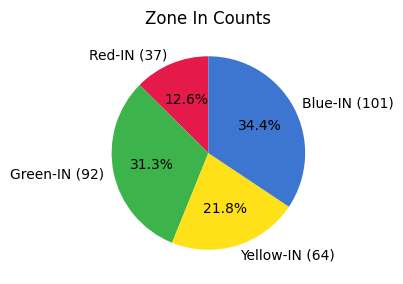

In [60]:
counts = [len(ids) for ids in zone_in_data.values()]

plt.figure(figsize=(4, 4))
plt.pie(
    counts,
    labels=[f"{ZONE_COLOR_NAMES[i]}-IN ({count})" for i, count in enumerate(counts)],
    autopct='%1.1f%%',
    startangle=90,
    colors=ZONE_HEX_COLORS
)
plt.title("Zone In Counts", fontsize=12)
plt.tight_layout()
plt.show()

In [61]:
print("Insights:")

total_vehicles_tracked = sum(len(trackers) for trackers in zone_in_data.values())
print(f"- Total Vehicle Count: {total_vehicles_tracked}")
print(f"- Busiest InZone: {ZONE_COLOR_NAMES[np.argmax(counts)]}-IN ({max(counts)} vehicles)")
print(f"- Quietest InZone: {ZONE_COLOR_NAMES[np.argmin(counts)]}-IN ({min(counts)} vehicles)")
print(f"- Average Vehicle Count: {total_vehicles_tracked / len(counts):.0f} vehicles")

Insights:
- Total Vehicle Count: 294
- Busiest InZone: Blue-IN (101 vehicles)
- Quietest InZone: Red-IN (37 vehicles)
- Average Vehicle Count: 74 vehicles


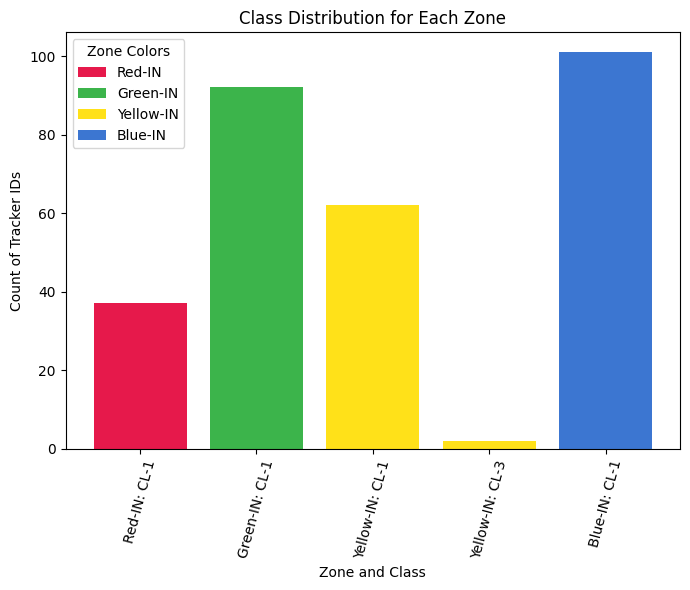

In [62]:
class_distributions = []

for color, trackers in zone_in_data.items():
    class_counts = Counter(trackers.values())
    class_distributions.append(class_counts)

fig, ax = plt.subplots(figsize=(7, 6))

for i, class_counts in enumerate(class_distributions):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    x = [f"{ZONE_COLOR_NAMES[i]}-IN: CL-{cls}" for cls in classes]

    ax.bar(x, counts, label=f"{ZONE_COLOR_NAMES[i]}-IN", color=ZONE_HEX_COLORS[i])

ax.set_title("Class Distribution for Each Zone", fontsize=12)
ax.set_xlabel("Zone and Class", fontsize=10)
ax.set_ylabel("Count of Tracker IDs", fontsize=10)
plt.xticks(rotation=75, fontsize=10)
plt.legend(title="Zone Colors")
plt.tight_layout()
plt.show()

In [63]:
print("Insights:")

overall_class_counts = sum(class_distributions, Counter())
unique_classes = set(overall_class_counts.keys())
print(f"- Total unique classes across all zones: {len(unique_classes)} ({sorted(unique_classes)})")
print(f"- Overall class counts across all zones:")
for  cls in overall_class_counts.keys():
    print(f"    - CL-{cls}: {overall_class_counts[cls]} vehicles")
      
print("- Common class in each zone:")
for i, zone_distribution in enumerate(class_distributions, start=1):
    most_common_class = zone_distribution.most_common(1)
    print(f"    - {ZONE_COLOR_NAMES[i-1]}-IN: CL-{most_common_class[0][0]} ({most_common_class[0][1]} vehicles)")

Insights:
- Total unique classes across all zones: 2 ([1, 3])
- Overall class counts across all zones:
    - CL-1: 292 vehicles
    - CL-3: 2 vehicles
- Common class in each zone:
    - Red-IN: CL-1 (37 vehicles)
    - Green-IN: CL-1 (92 vehicles)
    - Yellow-IN: CL-1 (62 vehicles)
    - Blue-IN: CL-1 (101 vehicles)


## Zone Out Data

In [64]:
zone_out_data = processor.detections_manager.counts
print(zone_out_data)

with open(zone_out_data_path, "w") as file:
    json_serializable_data = {
        int(zone): {
            int(class_id): list(map(int, tracker_ids))
            for class_id, tracker_ids in trackers.items()
        }
        for zone, trackers in zone_out_data.items()
    }
    json.dump(json_serializable_data, file, indent=4)

{2: {1: {2147, 2759, 1663, 2678, 2013, 2493}, 3: {1803, 3027}, 0: {2037}}, 3: {1: {1856, 1952, 2624, 1703, 1832, 2033, 2675, 1812, 2550, 3003, 2620, 1789}, 2: {3009, 1922, 2323}, 0: {2730, 2259}}, 0: {1: {1664, 2432, 1896, 1833, 2555}, 3: {2563, 2341, 2279, 1929, 2898, 3058, 2132, 2134, 1878, 2838, 2329, 2874, 3035, 2844, 2526, 2175}, 2: {2595, 2404, 3172, 2152, 2252, 3116, 2035, 2132, 1878, 2838, 1720, 2175}, 0: {2536}}, 1: {3: {2208, 1977, 2474}, 2: {2940}}}


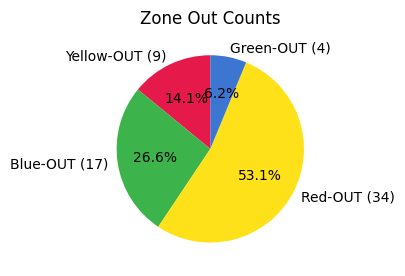

In [65]:
out_zone_totals = {out_zone_id: sum(len(trackers) for trackers in zone_in_ids.values()) for out_zone_id, zone_in_ids in zone_out_data.items()}
out_zone_ids = list(out_zone_totals.keys())
counts = list(out_zone_totals.values())

plt.figure(figsize=(4, 4))
plt.pie(
    counts,
   labels=[f"{ZONE_COLOR_NAMES[zone_id]}-OUT ({counts[idx]})" for idx, zone_id in enumerate(out_zone_ids)],
    autopct='%1.1f%%',
    startangle=90,
    colors=ZONE_HEX_COLORS
)
plt.title("Zone Out Counts", fontsize=12)
plt.tight_layout()
plt.show()

In [66]:
print("Insights:")

total_vehicles_tracked = sum(counts)
print(f"- Total Vehicle Count: {total_vehicles_tracked}")
print(f"- Busiest OutZone: {ZONE_COLOR_NAMES[np.argmax(counts)]}-OUT ({max(counts)} vehicles)")
print(f"- Quietest OutZone: {ZONE_COLOR_NAMES[np.argmin(counts)]}-OUT ({min(counts)} vehicles)")
print(f"- Average Vehicle Count: {total_vehicles_tracked / len(counts):.0f} vehicles")

Insights:
- Total Vehicle Count: 64
- Busiest OutZone: Yellow-OUT (34 vehicles)
- Quietest OutZone: Blue-OUT (4 vehicles)
- Average Vehicle Count: 16 vehicles


['Green-IN -> Yellow-OUT', 'Blue-IN -> Yellow-OUT', 'Red-IN -> Yellow-OUT', 'Green-IN -> Blue-OUT', 'Yellow-IN -> Blue-OUT', 'Red-IN -> Blue-OUT', 'Green-IN -> Red-OUT', 'Blue-IN -> Red-OUT', 'Yellow-IN -> Red-OUT', 'Red-IN -> Red-OUT', 'Blue-IN -> Green-OUT', 'Yellow-IN -> Green-OUT']
[6, 2, 1, 12, 3, 2, 5, 16, 12, 1, 3, 1]


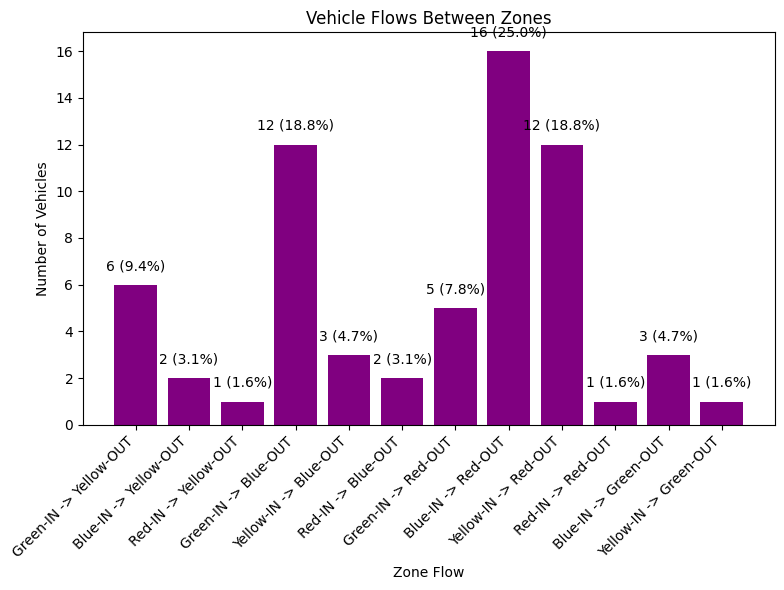

In [67]:
flows = []
counts_per_flow = []
for out_zone, in_zones in zone_out_data.items():
    for in_zone, tracker_ids in in_zones.items():
        flow_label = f"{ZONE_COLOR_NAMES[in_zone]}-IN -> {ZONE_COLOR_NAMES[out_zone]}-OUT"
        flows.append(flow_label)
        counts_per_flow.append(len(tracker_ids))

print(flows)
print(counts_per_flow)

total_vehicles = sum(counts_per_flow)
plt.figure(figsize=(8, 6))
bars = plt.bar(flows, counts_per_flow, color='purple')

for bar, count in zip(bars, counts_per_flow):
    percentage = (count / total_vehicles) * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f"{count} ({percentage:.1f}%)",
        ha='center', va='bottom', fontsize=10
    )

plt.title("Vehicle Flows Between Zones", fontsize=12)
plt.xlabel("Zone Flow", fontsize=10)
plt.ylabel("Number of Vehicles", fontsize=10)
plt.xticks(rotation=45, fontsize=10, ha="right")
plt.tight_layout()
plt.show()

In [68]:
print("Insights:")

max_flow_index = counts_per_flow.index(max(counts_per_flow))
print(f"- Flow with the maximum vehicles: {flows[max_flow_index]} ({counts_per_flow[max_flow_index]} vehicles)")

min_flow_index = counts_per_flow.index(min(counts_per_flow))
print(f"- Flow with the minimum vehicles: {flows[min_flow_index]} ({counts_per_flow[min_flow_index]} vehicles)")

print("- Percentage contribution of each flow:")
for flow, count in zip(flows, counts_per_flow):
    percentage = (count / total_vehicles) * 100
    print(f"    - {flow}: {count} vehicles ({percentage:.1f}%)")

average_vehicle_count = total_vehicles / len(flows)
print(f"- Average vehicle count per flow: {math.floor(average_vehicle_count):.0f}")

Insights:
- Flow with the maximum vehicles: Blue-IN -> Red-OUT (16 vehicles)
- Flow with the minimum vehicles: Red-IN -> Yellow-OUT (1 vehicles)
- Percentage contribution of each flow:
    - Green-IN -> Yellow-OUT: 6 vehicles (9.4%)
    - Blue-IN -> Yellow-OUT: 2 vehicles (3.1%)
    - Red-IN -> Yellow-OUT: 1 vehicles (1.6%)
    - Green-IN -> Blue-OUT: 12 vehicles (18.8%)
    - Yellow-IN -> Blue-OUT: 3 vehicles (4.7%)
    - Red-IN -> Blue-OUT: 2 vehicles (3.1%)
    - Green-IN -> Red-OUT: 5 vehicles (7.8%)
    - Blue-IN -> Red-OUT: 16 vehicles (25.0%)
    - Yellow-IN -> Red-OUT: 12 vehicles (18.8%)
    - Red-IN -> Red-OUT: 1 vehicles (1.6%)
    - Blue-IN -> Green-OUT: 3 vehicles (4.7%)
    - Yellow-IN -> Green-OUT: 1 vehicles (1.6%)
- Average vehicle count per flow: 5
